✅ 成功生成图片: calendar_output.png


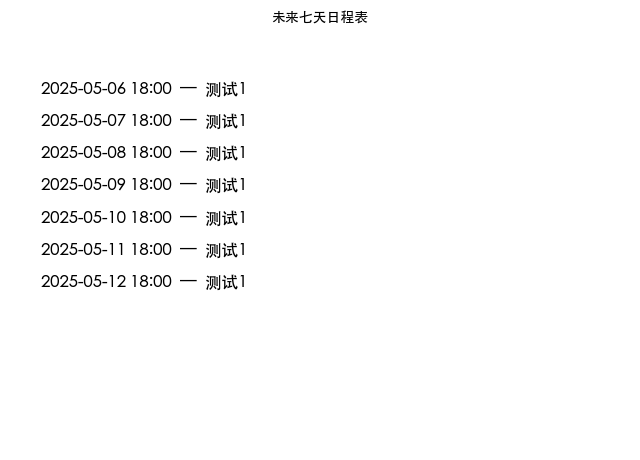

In [18]:
from icalendar import Calendar
from datetime import datetime, timedelta
from dateutil.rrule import rrulestr
from dateutil.tz import gettz
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# === 配置区域 ===
FILENAME = "calendar.ics"         # 本地文件路径
OUTPUT_IMG = "calendar_output.png"
DAYS_AHEAD = 7

# === 1. 解析事件（含RRULE和时区） ===
def parse_events_with_rrule(filename, days=7):
    with open(filename, 'rb') as f:
        cal = Calendar.from_ical(f.read())

    now = datetime.now(gettz("Asia/Kuala_Lumpur"))
    future = now + timedelta(days=days)
    events = []

    for component in cal.walk():
        if component.name == "VEVENT":
            summary = str(component.get("SUMMARY"))
            dtstart = component.decoded("DTSTART")
            timezone = dtstart.tzinfo

            if "RRULE" in component:
                rrule = rrulestr(str(component.get("RRULE").to_ical().decode()), dtstart=dtstart)
                for occur in rrule.between(now, future, inc=True):
                    events.append((summary, occur.astimezone(timezone)))
            else:
                if now <= dtstart <= future:
                    events.append((summary, dtstart))

    events.sort(key=lambda x: x[1])
    return events

# === 2. 生成图像（中文日程） ===
def generate_image(events, output_file):
    # 中文字体（如微软雅黑）
    font_path = '/System/Library/Fonts/STHeiti Medium.ttc'  # macOS 路径；Win/Linux 请替换
    prop = fm.FontProperties(fname=font_path)

    fig, ax = plt.subplots(figsize=(8, len(events) * 0.6 + 1))
    ax.axis('off')
    ax.set_title("未来七天日程表", fontsize=16, fontproperties=prop, weight='bold', pad=20)

    for i, (name, time) in enumerate(events):
        text = f"{time.strftime('%Y-%m-%d %H:%M')}  —  {name}"
        ax.text(0.05, 1 - (i + 1) * 0.08, text, fontsize=12, ha='left', va='top', fontproperties=prop)

    plt.savefig(output_file, bbox_inches='tight')
    print(f"✅ 成功生成图片: {output_file}")

# === 主程序 ===
if __name__ == "__main__":
    events = parse_events_with_rrule(FILENAME, DAYS_AHEAD)
    if events:
        generate_image(events, OUTPUT_IMG)
    else:
        print("⚠️ 没有找到未来 7 天的事件。")


✅ 月视图图片已生成: calendar_month_view.png


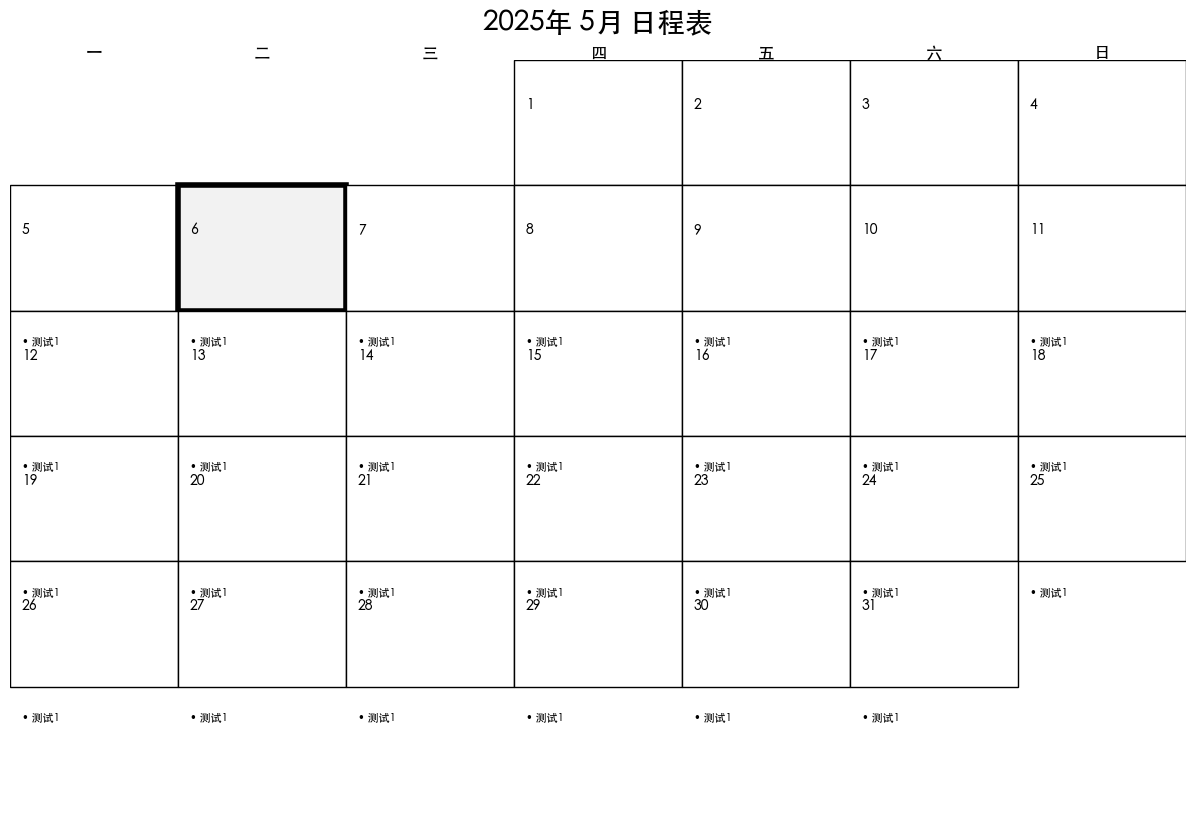

In [47]:
from icalendar import Calendar
from datetime import datetime, timedelta
from dateutil.rrule import rrulestr
from dateutil.tz import gettz
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import calendar

# === 配置区域 ===
FILENAME = "calendar.ics"               # 日历文件路径
OUTPUT_IMG = "calendar_month_view.png"  # 输出图片
FONT_PATH = "/System/Library/Fonts/STHeiti Medium.ttc"  # 中文字体路径（Mac）；Windows/Linux 请替换
TIMEZONE = gettz("Asia/Kuala_Lumpur")   # 时区

# === 1. 解析本月所有事件（含RRULE） ===
def parse_month_events(filename):
    with open(filename, 'rb') as f:
        cal = Calendar.from_ical(f.read())

    now = datetime.now(TIMEZONE)
    first_day = now.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    _, last_day = calendar.monthrange(now.year, now.month)
    end_date = first_day + timedelta(days=last_day)

    events_by_day = {}

    for component in cal.walk():
        if component.name == "VEVENT":
            summary = str(component.get("SUMMARY"))
            dtstart = component.decoded("DTSTART")
            timezone = dtstart.tzinfo or TIMEZONE

            def add_event(date):
                day = date.date()
                if first_day.date() <= day < end_date.date():
                    events_by_day.setdefault(day.day, []).append(summary)

            if "RRULE" in component:
                rule = rrulestr(str(component.get("RRULE").to_ical().decode()), dtstart=dtstart)
                for occur in rule.between(first_day, end_date, inc=True):
                    add_event(occur.astimezone(timezone))
            else:
                if first_day <= dtstart < end_date:
                    add_event(dtstart)

    return events_by_day, now.year, now.month

# === 2. 绘制月视图日历并高亮今天 ===
def generate_month_image(events_by_day, year, month, output_file):
    prop = fm.FontProperties(fname=FONT_PATH)
    cal = calendar.Calendar(firstweekday=0)
    month_days = list(cal.itermonthdays(year, month))
    if len(month_days) < 42:
        month_days.extend([0] * (42 - len(month_days)))

    today = datetime.now(TIMEZONE)
    today_day = today.day if today.month == month and today.year == year else -1

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"{year}年 {month}月 日程表", fontproperties=prop, fontsize=20, pad=20)
    ax.axis('off')

    for i in range(6):
        for j in range(7):
            idx = i * 7 + j
            day = month_days[idx]
            x0, y0 = j / 7, 1 - (i + 1) / 6
            width, height = 1 / 7, 1 / 6

            if day != 0:
                # 高亮今天
                if day == today_day:
                    ax.add_patch(plt.Rectangle((x0, y0), width, height, facecolor='#F2F2F2', edgecolor='black', lw=4))
                else:
                    ax.add_patch(plt.Rectangle((x0, y0), width, height, edgecolor='black', facecolor='white', lw=1))

                # 日期数字
                ax.text(x0 + 0.01, y0 + height - 0.05, str(day), fontproperties=prop,
                        fontsize=10, va='top', ha='left')

                # 事件列表
                events = events_by_day.get(day, [])
                for k, event in enumerate(events):
                    ax.text(x0 + 0.01, y0 + height - 0.2 - k * 0.12, f"• {event}", fontproperties=prop,
                            fontsize=8, va='top', ha='left', wrap=True)

    # 星期标题
    weekdays = ["一", "二", "三", "四", "五", "六", "日"]
    for i, wd in enumerate(weekdays):
        ax.text(i / 7 + 0.5 / 7, 1, wd, ha='center', va='bottom', fontsize=12, fontproperties=prop, weight='bold')

    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.01)
    plt.savefig(output_file, bbox_inches='tight')
    print(f"✅ 月视图图片已生成: {output_file}")

# === 主程序 ===
if __name__ == "__main__":
    events_by_day, year, month = parse_month_events(FILENAME)
    generate_month_image(events_by_day, year, month, OUTPUT_IMG)


✅ 月视图图片已生成: calendar_month_view.png


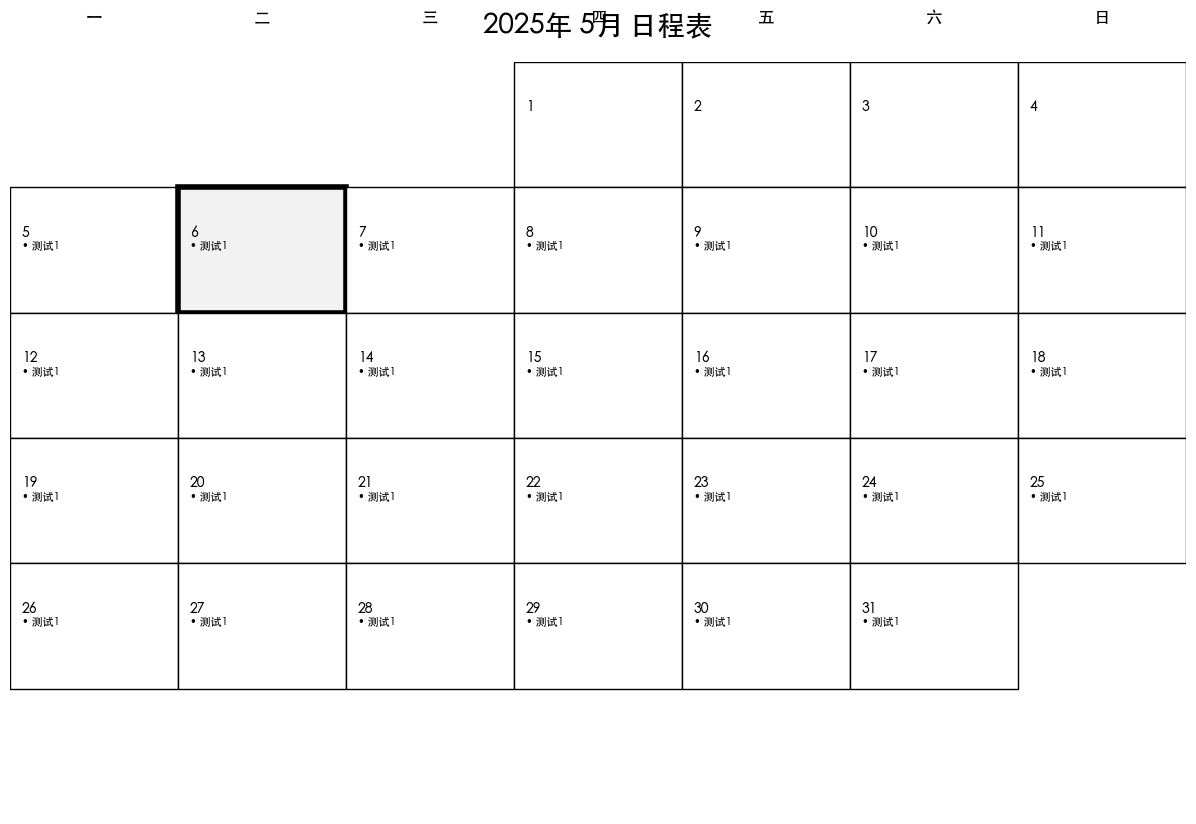

In [77]:
from icalendar import Calendar
from datetime import datetime, timedelta
from dateutil.rrule import rrulestr
from dateutil.tz import gettz
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import calendar

# === 配置区域 ===
FILENAME = "calendar.ics"               # 日历文件路径
OUTPUT_IMG = "calendar_month_view.png"  # 输出图片
FONT_PATH = "/System/Library/Fonts/STHeiti Medium.ttc"  # 中文字体路径（Mac）；Windows/Linux 请替换
TIMEZONE = gettz("Asia/Kuala_Lumpur")   # 时区

# === 1. 解析本月所有事件（含RRULE） ===
def parse_month_events(filename):
    with open(filename, 'rb') as f:
        cal = Calendar.from_ical(f.read())

    now = datetime.now(TIMEZONE)
    first_day = now.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    _, last_day = calendar.monthrange(now.year, now.month)
    end_date = first_day + timedelta(days=last_day)

    events_by_day = {}

    for component in cal.walk():
        if component.name == "VEVENT":
            summary = str(component.get("SUMMARY"))
            dtstart = component.decoded("DTSTART")
            timezone = dtstart.tzinfo or TIMEZONE

            def add_event(date):
                day = date.date()
                if first_day.date() <= day < end_date.date():
                    events_by_day.setdefault(day.day, []).append(summary)

            if "RRULE" in component:
                rule = rrulestr(str(component.get("RRULE").to_ical().decode()), dtstart=dtstart)
                for occur in rule.between(first_day, end_date, inc=True):
                    add_event(occur.astimezone(timezone))
            else:
                if first_day <= dtstart < end_date:
                    add_event(dtstart)

    return events_by_day, now.year, now.month

# === 2. 绘制月视图日历并高亮今天 ===
def generate_month_image(events_by_day, year, month, output_file):
    prop = fm.FontProperties(fname=FONT_PATH)
    cal = calendar.Calendar(firstweekday=0)
    month_days = list(cal.itermonthdays(year, month))
    if len(month_days) < 42:
        month_days.extend([0] * (42 - len(month_days)))

    today = datetime.now(TIMEZONE)
    today_day = today.day if today.month == month and today.year == year else -1

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"{year}年 {month}月 日程表", fontproperties=prop, fontsize=20, pad=20)
    ax.axis('off')

    for i in range(6):
        for j in range(7):
            idx = i * 7 + j
            day = month_days[idx]
            x0, y0 = j / 7, 1 - (i + 1) / 6
            width, height = 1 / 7, 1 / 6

            if day != 0:
                # 高亮今天
                if day == today_day:
                    ax.add_patch(plt.Rectangle((x0, y0), width, height, facecolor='#F2F2F2', edgecolor='black', lw=4))
                else:
                    ax.add_patch(plt.Rectangle((x0, y0), width, height, edgecolor='black', facecolor='white', lw=1))

                # 日期数字
                ax.text(x0 + 0.01, y0 + height - 0.05, str(day), fontproperties=prop,
                        fontsize=10, va='top', ha='left')

                # 事件列表
                events = events_by_day.get(day, [])
                for k, event in enumerate(events):
                    ax.text(x0 + 0.01, y0 + height - 0.07 - k * 0.12, f"• {event}", fontproperties=prop,
                            fontsize=8, va='top', ha='left', wrap=True)

    # 星期标题
    weekdays = ["一", "二", "三", "四", "五", "六", "日"]
    for i, wd in enumerate(weekdays):
        ax.text(i / 7 + 0.5 / 7, 1.05, wd, ha='center', va='bottom', fontsize=12, fontproperties=prop, weight='bold')

    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.01)
    plt.savefig(output_file, bbox_inches='tight')
    print(f"✅ 月视图图片已生成: {output_file}")

# === 主程序 ===
if __name__ == "__main__":
    events_by_day, year, month = parse_month_events(FILENAME)
    generate_month_image(events_by_day, year, month, OUTPUT_IMG)


✅ 月视图图片已生成: calendar_month_view.png


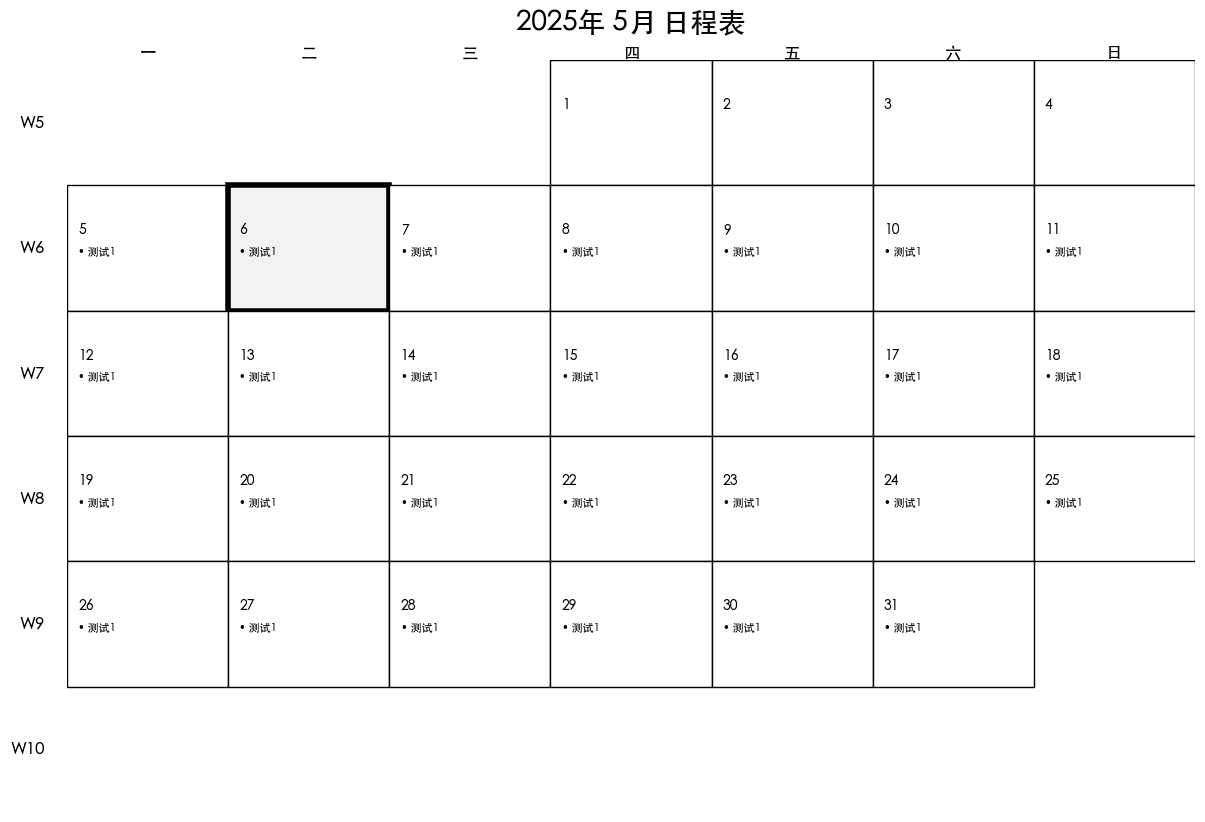

In [81]:
from icalendar import Calendar
from datetime import datetime, timedelta
from dateutil.rrule import rrulestr
from dateutil.tz import gettz
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import calendar

# === 配置区域 ===
FILENAME = "calendar.ics"               # 日历文件路径
OUTPUT_IMG = "calendar_month_view.png"  # 输出图片
FONT_PATH = "/System/Library/Fonts/STHeiti Medium.ttc"  # 中文字体路径（Mac）；Windows/Linux 请替换
TIMEZONE = gettz("Asia/Kuala_Lumpur")   # 时区

# === 1. 解析本月所有事件（含RRULE） ===
def parse_month_events(filename):
    with open(filename, 'rb') as f:
        cal = Calendar.from_ical(f.read())

    now = datetime.now(TIMEZONE)
    first_day = now.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    _, last_day = calendar.monthrange(now.year, now.month)
    end_date = first_day + timedelta(days=last_day)

    events_by_day = {}

    for component in cal.walk():
        if component.name == "VEVENT":
            summary = str(component.get("SUMMARY"))
            dtstart = component.decoded("DTSTART")
            timezone = dtstart.tzinfo or TIMEZONE

            def add_event(date):
                day = date.date()
                if first_day.date() <= day < end_date.date():
                    events_by_day.setdefault(day.day, []).append(summary)

            if "RRULE" in component:
                rule = rrulestr(str(component.get("RRULE").to_ical().decode()), dtstart=dtstart)
                for occur in rule.between(first_day, end_date, inc=True):
                    add_event(occur.astimezone(timezone))
            else:
                if first_day <= dtstart < end_date:
                    add_event(dtstart)

    return events_by_day, now.year, now.month

# === 2. 绘制月视图日历并高亮今天、标注W6开始的每周编号 ===
def generate_month_image(events_by_day, year, month, output_file):
    prop = fm.FontProperties(fname=FONT_PATH)
    cal = calendar.Calendar(firstweekday=0)
    month_days = list(cal.itermonthdays(year, month))
    if len(month_days) < 42:
        month_days.extend([0] * (42 - len(month_days)))

    today = datetime.now(TIMEZONE)
    today_day = today.day if today.month == month and today.year == year else -1
    today_idx = month_days.index(today_day) if today_day in month_days else -1
    week_offset = today_idx // 7 if today_idx >= 0 else 0

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"{year}年 {month}月 日程表", fontproperties=prop, fontsize=20, pad=20)
    ax.axis('off')

    for i in range(6):
        # 每周左侧标注：W6、W7...
        label = f"W{6 + i - week_offset}"
        ax.text(-0.02, 1 - (i + 0.5) / 6, label, fontproperties=prop,
                fontsize=12, ha='right', va='center', weight='bold')

        for j in range(7):
            idx = i * 7 + j
            day = month_days[idx]
            x0, y0 = j / 7, 1 - (i + 1) / 6
            width, height = 1 / 7, 1 / 6

            if day != 0:
                # 高亮今天
                if day == today_day:
                    ax.add_patch(plt.Rectangle((x0, y0), width, height, facecolor='#F2F2F2', edgecolor='black', lw=4))
                else:
                    ax.add_patch(plt.Rectangle((x0, y0), width, height, edgecolor='black', facecolor='white', lw=1))

                # 日期数字
                ax.text(x0 + 0.01, y0 + height - 0.05, str(day), fontproperties=prop,
                        fontsize=10, va='top', ha='left')

                # 事件列表
                events = events_by_day.get(day, [])
                for k, event in enumerate(events):
                    ax.text(x0 + 0.01, y0 + height - 0.08 - k * 0.12, f"• {event}", fontproperties=prop,
                            fontsize=8, va='top', ha='left', wrap=True)

    # 星期标题
    weekdays = ["一", "二", "三", "四", "五", "六", "日"]
    for i, wd in enumerate(weekdays):
        ax.text(i / 7 + 0.5 / 7, 1, wd, ha='center', va='bottom', fontsize=12, fontproperties=prop, weight='bold')

    plt.subplots_adjust(left=0.05, right=0.99, top=0.95, bottom=0.01)
    plt.savefig(output_file, bbox_inches='tight')
    print(f"✅ 月视图图片已生成: {output_file}")

# === 主程序 ===
if __name__ == "__main__":
    events_by_day, year, month = parse_month_events(FILENAME)
    generate_month_image(events_by_day, year, month, OUTPUT_IMG)


✅ 月视图图片已生成: calendar_month_view.png


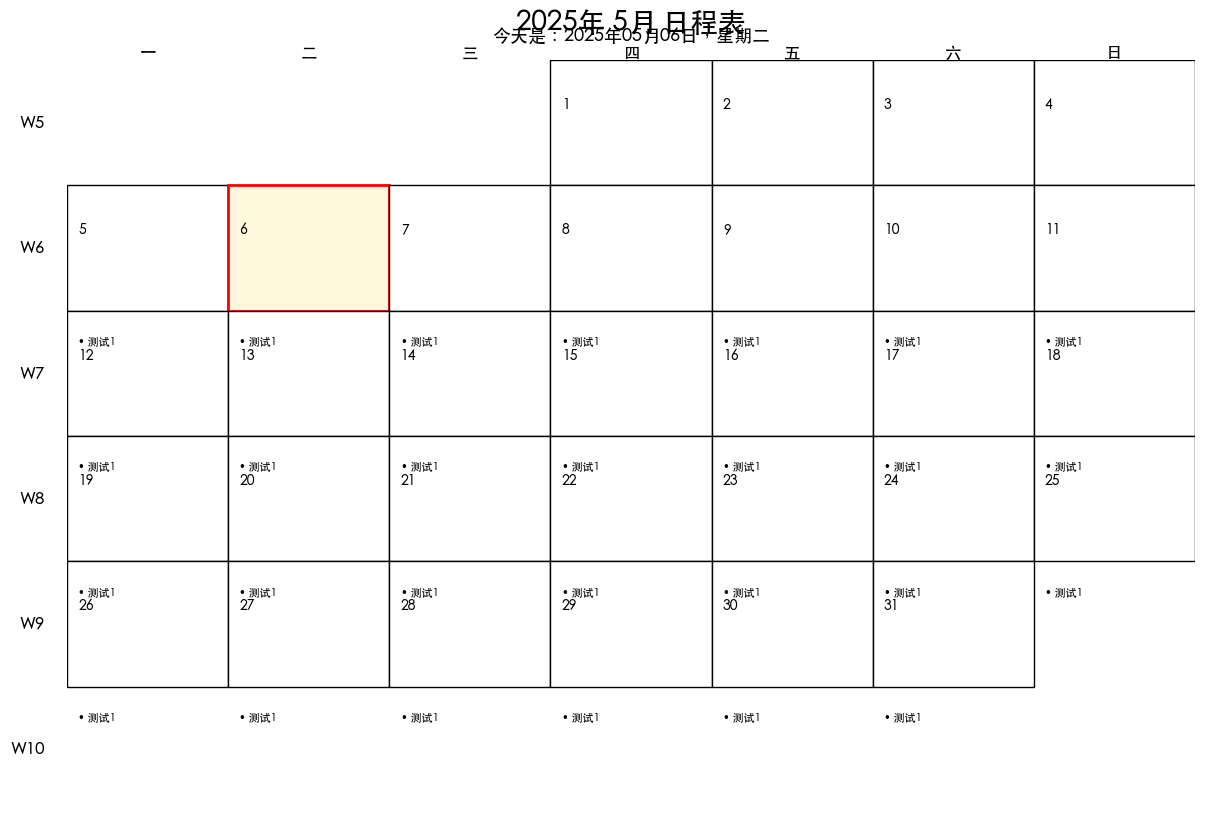

In [85]:
## from icalendar import Calendar
from datetime import datetime, timedelta
from dateutil.rrule import rrulestr
from dateutil.tz import gettz
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import calendar

# === 配置区域 ===
FILENAME = "calendar.ics"               # 日历文件路径
OUTPUT_IMG = "calendar_month_view.png"  # 输出图片路径
FONT_PATH = "/System/Library/Fonts/STHeiti Medium.ttc"  # 中文字体路径（macOS）；Windows/Linux 替换
TIMEZONE = gettz("Asia/Kuala_Lumpur")   # 时区

# === 中文星期函数 ===
def get_chinese_weekday(dt: datetime):
    weekdays = ["一", "二", "三", "四", "五", "六", "日"]
    return f"今天是：{dt.strftime('%Y年%m月%d日')}，星期{weekdays[dt.weekday()]}"

# === 1. 解析当前月的事件 ===
def parse_month_events(filename):
    with open(filename, 'rb') as f:
        cal = Calendar.from_ical(f.read())

    now = datetime.now(TIMEZONE)
    first_day = now.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    _, last_day = calendar.monthrange(now.year, now.month)
    end_date = first_day + timedelta(days=last_day)

    events_by_day = {}

    for component in cal.walk():
        if component.name == "VEVENT":
            summary = str(component.get("SUMMARY"))
            dtstart = component.decoded("DTSTART")
            timezone = dtstart.tzinfo or TIMEZONE

            def add_event(date):
                day = date.date()
                if first_day.date() <= day < end_date.date():
                    events_by_day.setdefault(day.day, []).append(summary)

            if "RRULE" in component:
                rule = rrulestr(str(component.get("RRULE").to_ical().decode()), dtstart=dtstart)
                for occur in rule.between(first_day, end_date, inc=True):
                    add_event(occur.astimezone(timezone))
            else:
                if first_day <= dtstart < end_date:
                    add_event(dtstart)

    return events_by_day, now.year, now.month

# === 2. 绘制日历图像 ===
def generate_month_image(events_by_day, year, month, output_file):
    prop = fm.FontProperties(fname=FONT_PATH)
    cal = calendar.Calendar(firstweekday=0)
    month_days = list(cal.itermonthdays(year, month))
    if len(month_days) < 42:
        month_days.extend([0] * (42 - len(month_days)))

    today = datetime.now(TIMEZONE)
    today_day = today.day if today.month == month and today.year == year else -1
    today_idx = month_days.index(today_day) if today_day in month_days else -1
    week_offset = today_idx // 7 if today_idx >= 0 else 0

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"{year}年 {month}月 日程表", fontproperties=prop, fontsize=20, pad=20)

    # 顶部：今天是周几
    subtitle = get_chinese_weekday(today)
    ax.text(0.5, 1.02, subtitle, fontproperties=prop, fontsize=13,
            ha='center', va='bottom', transform=ax.transAxes)

    ax.axis('off')

    for i in range(6):
        # 左侧周标记
        label = f"W{6 + i - week_offset}"
        ax.text(-0.02, 1 - (i + 0.5) / 6, label, fontproperties=prop,
                fontsize=12, ha='right', va='center', weight='bold')

        for j in range(7):
            idx = i * 7 + j
            day = month_days[idx]
            x0, y0 = j / 7, 1 - (i + 1) / 6
            width, height = 1 / 7, 1 / 6

            if day != 0:
                # 高亮今天
                if day == today_day:
                    ax.add_patch(plt.Rectangle((x0, y0), width, height, facecolor='#FFF8DC', edgecolor='red', lw=2))
                else:
                    ax.add_patch(plt.Rectangle((x0, y0), width, height, edgecolor='black', facecolor='white', lw=1))

                # 日期
                ax.text(x0 + 0.01, y0 + height - 0.05, str(day), fontproperties=prop,
                        fontsize=10, va='top', ha='left')

                # 事件
                events = events_by_day.get(day, [])
                for k, event in enumerate(events):
                    ax.text(x0 + 0.01, y0 + height - 0.2 - k * 0.12, f"• {event}",
                            fontproperties=prop, fontsize=8, va='top', ha='left', wrap=True)

    # 顶部星期名
    weekdays = ["一", "二", "三", "四", "五", "六", "日"]
    for i, wd in enumerate(weekdays):
        ax.text(i / 7 + 0.5 / 7, 1, wd, ha='center', va='bottom',
                fontsize=12, fontproperties=prop, weight='bold')

    plt.subplots_adjust(left=0.05, right=0.99, top=0.95, bottom=0.01)
    plt.savefig(output_file, bbox_inches='tight')
    print(f"✅ 月视图图片已生成: {output_file}")

# === 主程序 ===
if __name__ == "__main__":
    events_by_day, year, month = parse_month_events(FILENAME)
    generate_month_image(events_by_day, year, month, OUTPUT_IMG)


In [32]:
import matplotlib.pyplot as plt
from datetime import datetime
from zhdate import ZhDate
from matplotlib import rcParams

import matplotlib.font_manager as fm
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(fm.FontProperties(fname=font).get_name())


# 设置支持中文的字体（macOS 推荐）
rcParams['font.family'] = 'Heiti TC'  # 或 'PingFang SC'

# 获取今天的日期
today = datetime.today()
today_in_chinese = ZhDate.today()
day = today.day
weekday = today.strftime('%A')  # e.g., 'Monday'
month_year = today.strftime('%B %Y')  # e.g., 'May 2025'

# 设置画布
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_facecolor('#f9f9f9')
ax.set_axis_off()

# 显示顶部：星期几
ax.text(0.5, 0.9, weekday, fontsize=28, weight='bold', ha='center', color='#4A90E2')

# 显示中部：今天的日期（放大）
ax.text(0.5, 0.5, str(day), fontsize=120, weight='bold', ha='center', va='center', color='#333')

# 显示底部：月份与年份
ax.text(0.5, 0.15, month_year, fontsize=20, ha='center', color='#777')
ax.text(0.5, 0.1, today_in_chinese.chinese(), fontsize=20, ha ='center', color= 'black')

plt.tight_layout()
plt.show()


Hiragino Sans CNS
Times New Roman
Sublima
DengXian
Sana
Times
STIXSizeFourSym
Now
Noto Sans Khudawadi
Apple LiGothic
STIXIntegralsUpSm
TT Chocolates
.SF Soft Numeric
Osaka
Noto Serif Balinese
Al Tarikh
Noto Sans Adlam
Tahoma
TT Chocolates
Noto Sans Hanifi Rohingya
Modernia
Kannada Sangam MN
FZDaHei-B02S
Noto Sans Old Italic
Verdana
STIXGeneral
Noto Sans Mongolian
System Font
Noto Sans Bamum
Klee
AgencyFB
.SF Compact
Apple Braille
Noto Sans Old South Arabian
TT Chocolates
Hiragino Maru Gothic Pro
LingWai SC
Noto Sans Miao
Arial Hebrew
TT Chocolates
Apple Symbols
Noto Sans Old Turkic
STIXSizeThreeSym
Now
Blacker Display
STIXVariants
Hiragino Sans
FRIZON
Now Alt
Hiragino Sans
Motley Forces
Arapey
Noto Sans Warang Citi
Hiragino Sans
Noto Sans Nabataean
Menlo
Kannada MN
Tsukushi A Round Gothic
Alibaba PuHuiTi
DengXian
Diwan Kufi
Gurmukhi MN
Galvji
.SF Armenian
Noto Sans Ugaritic
Symbol
FZCuHeiSongS-B-GB
Ayuthaya
Nanum Gothic
Noto Sans Masaram Gondi
Tamil Sangam MN
.SF Armenian Rounded
BM Ha

RuntimeError: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime
from zhdate import ZhDate

# 获取当前日期
today = datetime.today()
day = today.day
year, month = today.year, today.month

# 中文星期映射
weekdays_cn = ['星期一', '星期二', '星期三', '星期四', '星期五', '星期六', '星期日']
weekday_cn = weekdays_cn[today.weekday()]

# 获取农历日期（完整中文字符串）
lunar_str = ZhDate.today().to_chinese()  # 如“农历二月廿八”

# 中文年月字符串
month_year_cn = f"{year}年{month}月"

# 创建画布
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_facecolor('#fefefe')  # 白色背景
ax.set_axis_off()

# 顶部：中文星期
ax.text(0.5, 0.9, weekday_cn, fontsize=26, weight='bold', ha='center', color='#d43f3a')

# 中部：放大显示“几号”
ax.text(0.5, 0.5, str(day), fontsize=120, weight='bold', ha='center', va='center', color='#222')

# 底部：年月 + 农历
ax.text(0.5, 0.18, f"{month_year_cn}  {lunar_str}", fontsize=18, ha='center', color='#777')

# 显示图像
plt.tight_layout()
plt.show()

AttributeError: 'ZhDate' object has no attribute 'to_chinese'

In [18]:
import matplotlib.pyplot as plt
from datetime import datetime
from zhdate import ZhDate

# 获取今天
today = ZhDate.today()
print(today.chinese())

二零二五年四月初九 乙巳年 (蛇年)
